### Setup and imports

In [1]:
import time

import numpy as np
import scipy as sp
import scipy.stats
import tensorflow as tf
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
import seaborn as sb
from IPython.display import HTML, display

from gcn.models import GCN
from gcn import utils as gcn_utils

#mpl.rc('animation', embed_limit=50 * 1024 * 1024) # In bytes; default limit in 20MB
VID = 'animations/l={l}-k={k}-p_inner={p_inner}-p_outer={p_outer}-f_mult={f_mult}-f_sigma={f_sigma}.mp4'

### Network drawing routines

In [2]:
def network_colors(glk, labels, ref_nodes=[], lmin=0.0, lmax=1.0):
    g, l, k = glk
    
    # Generate colormap
    cmap = mpl.cm.get_cmap('viridis')
    norm = mpl.colors.Normalize(vmin=lmin, vmax=lmax)
    cats = np.array(sb.color_palette(n_colors=l))
    
    # Compute colors
    node_colors = cats[np.argmax(labels, 1)]
    node_colors[ref_nodes] = [0, 0, 0]
    edgecolors = cmap(norm(labels[range(labels.shape[0]), np.argmax(labels, 1)]))
    
    return node_colors, edgecolors

_network_layouts = {}
def draw_network(glk, labels=None, ref_nodes=[], lmin=0.0, lmax=1.0, ax=None, relayout=False):
    if isinstance(glk, tuple):
        g, l, k = glk
    else:
        g, l, k = glk, None, None
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    else:
        fig = ax.figure
    
    if relayout or g not in _network_layouts:
        _network_layouts[g] = nx.drawing.layout.spring_layout(g)
    layout = _network_layouts[g]
    
    if labels is None:
        assert len(ref_nodes) == 0
        assert l is None
        assert k is None
        nx.draw_networkx(g, pos=layout, ax=ax, node_color='#65cb5e')
        node_collection = None
        edge_collection = None
        text_items = None
    else:
        assert l is not None
        assert k is not None
        # Plot nodes, edges and labels
        node_colors, edgecolors = network_colors(glk, labels, ref_nodes=ref_nodes, lmin=lmin, lmax=lmax)
        node_collection = nx.draw_networkx_nodes(g, pos=layout, ax=ax,
                                                 node_color=node_colors,
                                                 edgecolors=edgecolors,
                                                 linewidths=2)
        edge_collection = nx.draw_networkx_edges(g, pos=layout, ax=ax)
        text_items = nx.draw_networkx_labels(g, pos=layout, font_color='#e4e4e4', ax=ax)
        
        # Add the colorbar
        color_sm = plt.cm.ScalarMappable(cmap='viridis', norm=mpl.colors.Normalize(vmin=lmin, vmax=lmax))
        color_sm.set_array([])
        fig.colorbar(color_sm)
    
    return (fig, ax), (node_collection, edge_collection, text_items)

### Try out feature randomisation

In [3]:
def feature_sample(mode, scale=.2, size=None):
    #α = alpha
    #β = (α - 1) / mode - α + 2
    #return np.random.beta(α, β, size=size)
    return np.random.normal(mode, scale, size=size)

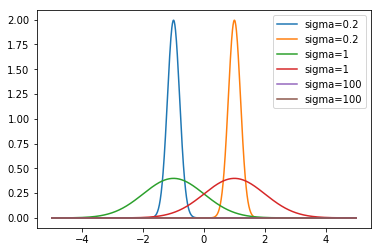

In [4]:
for sigma in [.2, 1, 100]:
    x = np.linspace(-5, 5, 1000)
    np.c_
    plt.plot(x, np.c_[scipy.stats.norm.pdf(x, -1, sigma), scipy.stats.norm.pdf(x, 1, sigma)],
             label='sigma={}'.format(sigma))
    #plt.hist(feature_sample(1, i, size=1000), normed=True, bins=50, alpha=.6)
plt.legend()

### GCN training setup

#### Initial setup

Base options for the model

In [5]:
flags = tf.app.flags
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 200, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 16, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0, #0.5,
                   'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 0, #5e-4,
                   'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')

In [6]:
def initialise_arrays(labels, mult, sigma, training_nodes):
    # Generate initial noised features
    features_noise = np.stack([np.concatenate([feature_sample(2 * v - 1, scale=sigma, size=mult)
                                               for v in label_values])
                               for label_values in labels])
    features = gcn_utils.preprocess_features(sp.sparse.lil_matrix(features_noise))

    # Generate training and validation arrays
    train_mask = gcn_utils.sample_mask(training_nodes, labels.shape[0])
    val_mask = np.logical_not(train_mask)

    labels_train = np.zeros(labels.shape)
    labels_val = np.zeros(labels.shape)

    labels_train[train_mask, :] = labels[train_mask, :]
    labels_val[val_mask, :] = labels[val_mask, :]
    
    return {
        'features': features,
        'train_mask': train_mask,
        'val_mask': val_mask,
        'labels': labels,
        'labels_train': labels_train,
        'labels_val': labels_val,
    }

In [7]:
def initialise_model_session(g, labels, mult, sigma, training_nodes):
    arrays = initialise_arrays(labels, mult, sigma, training_nodes)
    
    # Finish parameterising the model
    support = [gcn_utils.preprocess_adj(nx.adjacency_matrix(g))]
    placeholders = {
        'support': [tf.sparse_placeholder(tf.float32) for _ in range(len(support))],
        'features': tf.sparse_placeholder(tf.float32, shape=tf.constant(arrays['features'][2], dtype=tf.int64)),
        'labels': tf.placeholder(tf.float32, shape=(None, arrays['labels_train'].shape[1])),
        'labels_mask': tf.placeholder(tf.int32),
        'dropout': tf.placeholder_with_default(0., shape=()),
        'num_features_nonzero': tf.placeholder(tf.int32)  # helper variable for sparse dropout
    }
    arrays['support'] = support
    arrays['placeholders'] = placeholders
    
    model = GCN(placeholders, input_dim=arrays['features'][2][1], logging=True)
    session = tf.Session()
    session.run(tf.global_variables_initializer())
    
    return model, arrays, session

In [8]:
def evaluate_model(model, arrays, session):
    t_test = time.time()
    feed_dict_val = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                  arrays['labels_val'], arrays['val_mask'],
                                                  arrays['placeholders'])
    outs_val = session.run([model.loss, model.accuracy], feed_dict=feed_dict_val)
    return outs_val[0], outs_val[1], (time.time() - t_test)

def model_predict(model, arrays, session):
    feed_dict_pred = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                   arrays['labels'], np.ones(arrays['labels'].shape[0]),
                                                   arrays['placeholders'])
    return session.run(model.predict(), feed_dict=feed_dict_pred)

#### Model training

In [9]:
def legend_text(epoch, t, train_loss, train_acc, val_loss, val_acc):
    return ("epoch: {:4d} time={:.5f}\n"
            "train_loss={:.5f} train_acc={:.5f}\n"
            "val_loss={:.5f} val_acc={:.5f}\n").format(epoch, time.time() - t,
                                                       train_loss, train_acc, val_loss, val_acc)

def build_train_animation(glk, labels, mult, sigma,
                          training_nodes=None, community_training_pct=.2,
                          log=True):
    g, l, k = glk
    
    if training_nodes is None:
        trains_per_cty = int(np.round(k * community_training_pct))
        training_nodes = np.concatenate([np.random.choice(range(c * k, (c + 1) * k),
                                                          trains_per_cty, replace=False)
                                         for c in range(l)])
    
    # Get the model
    model, arrays, session = initialise_model_session(g, labels, mult, sigma, training_nodes)
    
    # Prepare plotting
    (fig, ax), (node_collection, _, _) = draw_network((g, l, k), labels=labels,
                                                      ref_nodes=np.where(arrays['train_mask'])[0])
    legend = ax.text(.5, 1, legend_text(0, 0, 0, 0, 0, 0),
                     ha='center', va='bottom', transform=ax.transAxes,
                     bbox=dict(facecolor='white', alpha=0.8))
    
    def init_plot():
        legend.set_text(legend_text(0, 0, 0, 0, 0, 0))
        node_collection.set_color(np.zeros((labels.shape[0], 4)))
        node_collection.set_edgecolors(np.zeros((labels.shape[0], 4)))
        return node_collection, legend

    cost_val = []
    def train_step(frame):
        t = time.time()

        feed_dict = gcn_utils.construct_feed_dict(arrays['features'], arrays['support'],
                                                  arrays['labels_train'], arrays['train_mask'],
                                                  arrays['placeholders'])
        feed_dict.update({arrays['placeholders']['dropout']: flags.FLAGS.dropout})

        outs = session.run([model.opt_op, model.loss, model.accuracy], feed_dict=feed_dict)
        cost, acc, duration = evaluate_model(model, arrays, session)
        cost_val.append(cost)

        if log:
            print("Epoch:", '%04d' % (frame + 1), "train_loss={:.5f}".format(outs[1]),
                  "train_acc={:.5f}".format(outs[2]), "val_loss={:.5f}".format(cost),
                  "val_acc={:.5f}".format(acc), "time={:.5f}".format(time.time() - t))
        
        legend.set_text(legend_text(frame, t, outs[1], outs[2], cost, acc))
        
        preds = model_predict(model, arrays, session)
        node_colors, edgecolors = network_colors((g, l, k), preds,
                                                 ref_nodes=np.where(arrays['train_mask'])[0])
        node_collection.set_color(node_colors)
        node_collection.set_edgecolors(edgecolors)

        return node_collection, legend

    def model_frames():
        counter = 0
        while True:
            if (counter > flags.FLAGS.early_stopping and
                    cost_val[-1] > np.mean(cost_val[-(flags.FLAGS.early_stopping+1):-1])):
                if log:
                    print("Early stopping.")
                return
            else:
                yield counter
                counter += 1

    anim = mpl.animation.FuncAnimation(fig, train_step, blit=True,
                                       init_func=init_plot,
                                       interval=100,
                                       save_count=flags.FLAGS.epochs,
                                       frames=model_frames(),
                                       repeat=False)
    plt.close()
    return anim, (model, arrays, session)

### Test random graphs

**Random graphs generators:**
* [Planted Partition](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.generators.community.planted_partition_graph.html#networkx.generators.community.planted_partition_graph)
* [Lancichinetti–Fortunato–Radicchi benchmark](https://en.wikipedia.org/wiki/Lancichinetti%E2%80%93Fortunato%E2%80%93Radicchi_benchmark)

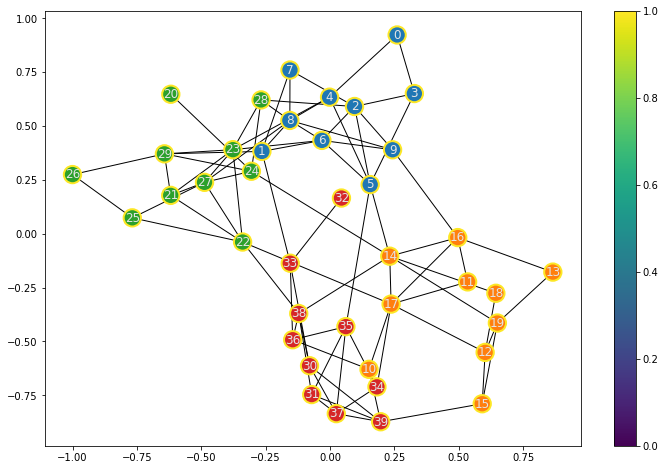

In [10]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = .2

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network((g, l, k), labels=labels);

In [11]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.30912 train_acc=0.50000 val_loss=1.32096 val_acc=0.50000 time=0.01899
Epoch: 0002 train_loss=1.28372 train_acc=0.50000 val_loss=1.29470 val_acc=0.50000 time=0.00186
Epoch: 0003 train_loss=1.25841 train_acc=0.50000 val_loss=1.26838 val_acc=0.50000 time=0.00187
Epoch: 0004 train_loss=1.23291 train_acc=0.50000 val_loss=1.24209 val_acc=0.50000 time=0.00181
Epoch: 0005 train_loss=1.20723 train_acc=0.50000 val_loss=1.21590 val_acc=0.50000 time=0.00164
Epoch: 0006 train_loss=1.18157 train_acc=0.50000 val_loss=1.18979 val_acc=0.50000 time=0.00202
Epoch: 0007 train_loss=1.15590 train_acc=0.50000 val_loss=1.16378 val_acc=0.50000 time=0.00165
Epoch: 0008 train_loss=1.13032 train_acc=0.50000 val_loss=1.13793 val_acc=0.53125 time=0.00162
Epoch: 0009 train_loss=1.10488 train_acc=0.75000 val_loss=1.11227 val_acc=0.59375 time=0.00157
Epoch: 0010 train_loss=1.07956 train_acc=0.75000 val_loss=1.08683 val_acc=0.59375 time=0.00172
Epoch: 0011 train_loss=1.05445 train_acc=0.75000 v

Epoch: 0088 train_loss=0.10843 train_acc=1.00000 val_loss=0.09915 val_acc=1.00000 time=0.00205
Epoch: 0089 train_loss=0.10475 train_acc=1.00000 val_loss=0.09672 val_acc=1.00000 time=0.00282
Epoch: 0090 train_loss=0.10123 train_acc=1.00000 val_loss=0.09442 val_acc=1.00000 time=0.00235
Epoch: 0091 train_loss=0.09791 train_acc=1.00000 val_loss=0.09224 val_acc=1.00000 time=0.00163
Epoch: 0092 train_loss=0.09471 train_acc=1.00000 val_loss=0.09016 val_acc=1.00000 time=0.00841
Epoch: 0093 train_loss=0.09165 train_acc=1.00000 val_loss=0.08817 val_acc=1.00000 time=0.00192
Epoch: 0094 train_loss=0.08870 train_acc=1.00000 val_loss=0.08627 val_acc=1.00000 time=0.00215
Epoch: 0095 train_loss=0.08589 train_acc=1.00000 val_loss=0.08446 val_acc=1.00000 time=0.00366
Epoch: 0096 train_loss=0.08319 train_acc=1.00000 val_loss=0.08272 val_acc=1.00000 time=0.00241
Epoch: 0097 train_loss=0.08061 train_acc=1.00000 val_loss=0.08106 val_acc=1.00000 time=0.00202
Epoch: 0098 train_loss=0.07814 train_acc=1.00000 v

Epoch: 0175 train_loss=0.01646 train_acc=1.00000 val_loss=0.04273 val_acc=0.96875 time=0.00180
Epoch: 0176 train_loss=0.01624 train_acc=1.00000 val_loss=0.04257 val_acc=0.96875 time=0.00189
Epoch: 0177 train_loss=0.01602 train_acc=1.00000 val_loss=0.04242 val_acc=0.96875 time=0.00191
Epoch: 0178 train_loss=0.01581 train_acc=1.00000 val_loss=0.04227 val_acc=0.96875 time=0.00187
Epoch: 0179 train_loss=0.01560 train_acc=1.00000 val_loss=0.04213 val_acc=0.96875 time=0.00189
Epoch: 0180 train_loss=0.01540 train_acc=1.00000 val_loss=0.04198 val_acc=0.96875 time=0.00334
Epoch: 0181 train_loss=0.01520 train_acc=1.00000 val_loss=0.04184 val_acc=0.96875 time=0.00217
Epoch: 0182 train_loss=0.01501 train_acc=1.00000 val_loss=0.04170 val_acc=0.96875 time=0.00167
Epoch: 0183 train_loss=0.01481 train_acc=1.00000 val_loss=0.04156 val_acc=0.96875 time=0.00171
Epoch: 0184 train_loss=0.01463 train_acc=1.00000 val_loss=0.04142 val_acc=0.96875 time=0.00182
Epoch: 0185 train_loss=0.01444 train_acc=1.00000 v

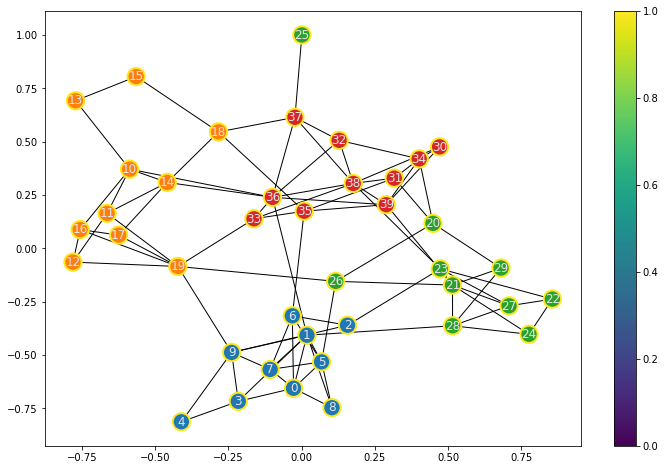

In [15]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network((g, l, k), labels=labels);

In [16]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=3.98139 train_acc=0.12500 val_loss=2.37665 val_acc=0.25000 time=0.02172
Epoch: 0002 train_loss=2.64876 train_acc=0.12500 val_loss=2.43718 val_acc=0.25000 time=0.00227
Epoch: 0003 train_loss=2.49725 train_acc=0.25000 val_loss=2.50627 val_acc=0.25000 time=0.00156
Epoch: 0004 train_loss=2.44320 train_acc=0.25000 val_loss=2.47212 val_acc=0.25000 time=0.00276
Epoch: 0005 train_loss=2.30489 train_acc=0.25000 val_loss=2.36045 val_acc=0.25000 time=0.00243
Epoch: 0006 train_loss=2.10144 train_acc=0.25000 val_loss=2.19851 val_acc=0.28125 time=0.00230
Epoch: 0007 train_loss=1.85883 train_acc=0.25000 val_loss=2.01503 val_acc=0.28125 time=0.00532
Epoch: 0008 train_loss=1.60828 train_acc=0.25000 val_loss=1.85635 val_acc=0.31250 time=0.00262
Epoch: 0009 train_loss=1.40664 train_acc=0.25000 val_loss=1.90883 val_acc=0.31250 time=0.00409
Epoch: 0010 train_loss=1.49287 train_acc=0.25000 val_loss=2.07007 val_acc=0.28125 time=0.00279
Epoch: 0011 train_loss=1.70025 train_acc=0.25000 v

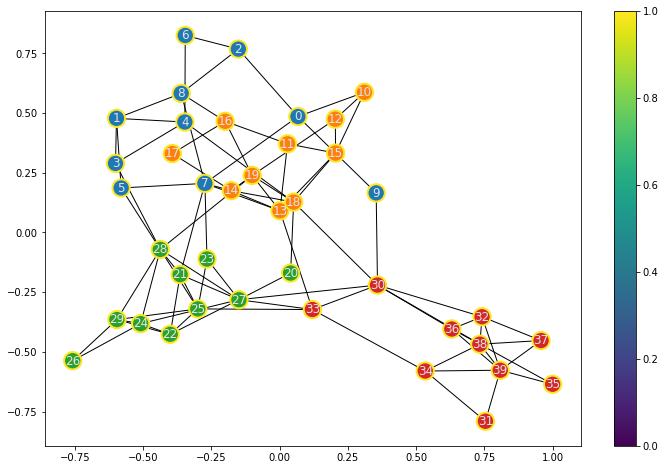

In [19]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 5
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network((g, l, k), labels=labels);

In [20]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.42875 train_acc=0.50000 val_loss=1.42122 val_acc=0.28125 time=0.02568
Epoch: 0002 train_loss=1.40424 train_acc=0.50000 val_loss=1.40172 val_acc=0.43750 time=0.00204
Epoch: 0003 train_loss=1.38191 train_acc=0.50000 val_loss=1.38309 val_acc=0.43750 time=0.00216
Epoch: 0004 train_loss=1.36130 train_acc=0.50000 val_loss=1.36434 val_acc=0.46875 time=0.00232
Epoch: 0005 train_loss=1.34091 train_acc=0.62500 val_loss=1.34566 val_acc=0.65625 time=0.00248
Epoch: 0006 train_loss=1.32149 train_acc=0.75000 val_loss=1.32709 val_acc=0.71875 time=0.00208
Epoch: 0007 train_loss=1.30151 train_acc=0.75000 val_loss=1.30903 val_acc=0.71875 time=0.00420
Epoch: 0008 train_loss=1.28197 train_acc=0.75000 val_loss=1.29150 val_acc=0.71875 time=0.00292
Epoch: 0009 train_loss=1.26294 train_acc=0.75000 val_loss=1.27363 val_acc=0.71875 time=0.00297
Epoch: 0010 train_loss=1.24335 train_acc=0.75000 val_loss=1.25522 val_acc=0.71875 time=0.00298
Epoch: 0011 train_loss=1.22317 train_acc=0.75000 v

Epoch: 0088 train_loss=0.05773 train_acc=1.00000 val_loss=0.13564 val_acc=0.96875 time=0.00232
Epoch: 0089 train_loss=0.05534 train_acc=1.00000 val_loss=0.13403 val_acc=0.96875 time=0.00193
Epoch: 0090 train_loss=0.05309 train_acc=1.00000 val_loss=0.13251 val_acc=0.96875 time=0.00245
Epoch: 0091 train_loss=0.05095 train_acc=1.00000 val_loss=0.13109 val_acc=0.96875 time=0.00210
Epoch: 0092 train_loss=0.04894 train_acc=1.00000 val_loss=0.12976 val_acc=0.96875 time=0.00246
Epoch: 0093 train_loss=0.04703 train_acc=1.00000 val_loss=0.12851 val_acc=0.96875 time=0.00184
Epoch: 0094 train_loss=0.04523 train_acc=1.00000 val_loss=0.12734 val_acc=1.00000 time=0.00285
Epoch: 0095 train_loss=0.04352 train_acc=1.00000 val_loss=0.12624 val_acc=1.00000 time=0.00182
Epoch: 0096 train_loss=0.04191 train_acc=1.00000 val_loss=0.12521 val_acc=1.00000 time=0.00269
Epoch: 0097 train_loss=0.04038 train_acc=1.00000 val_loss=0.12424 val_acc=1.00000 time=0.00616
Epoch: 0098 train_loss=0.03894 train_acc=1.00000 v

Epoch: 0175 train_loss=0.00785 train_acc=1.00000 val_loss=0.10872 val_acc=0.96875 time=0.00202
Epoch: 0176 train_loss=0.00775 train_acc=1.00000 val_loss=0.10869 val_acc=0.96875 time=0.00189
Epoch: 0177 train_loss=0.00765 train_acc=1.00000 val_loss=0.10867 val_acc=0.96875 time=0.00229
Epoch: 0178 train_loss=0.00756 train_acc=1.00000 val_loss=0.10864 val_acc=0.96875 time=0.00198
Epoch: 0179 train_loss=0.00746 train_acc=1.00000 val_loss=0.10861 val_acc=0.96875 time=0.00660
Epoch: 0180 train_loss=0.00737 train_acc=1.00000 val_loss=0.10859 val_acc=0.96875 time=0.00345
Epoch: 0181 train_loss=0.00728 train_acc=1.00000 val_loss=0.10856 val_acc=0.96875 time=0.00184
Epoch: 0182 train_loss=0.00719 train_acc=1.00000 val_loss=0.10854 val_acc=0.96875 time=0.00216
Epoch: 0183 train_loss=0.00710 train_acc=1.00000 val_loss=0.10851 val_acc=0.96875 time=0.00437
Epoch: 0184 train_loss=0.00702 train_acc=1.00000 val_loss=0.10849 val_acc=0.96875 time=0.00530
Epoch: 0185 train_loss=0.00693 train_acc=1.00000 v

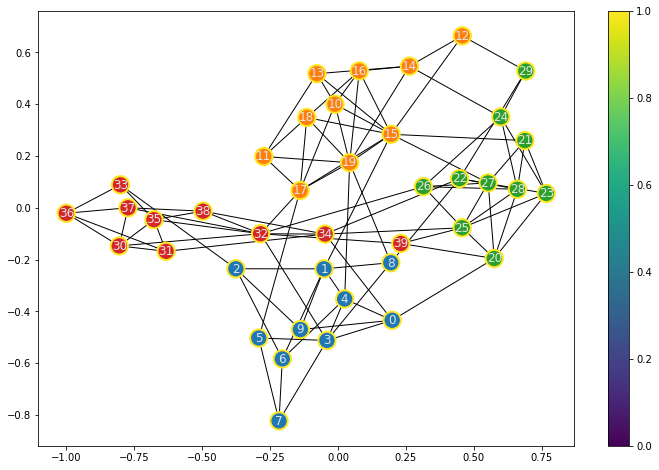

In [23]:
# Parameters
l = 4
k = 10
p_inner = .4
p_outer = .02
feature_mult = 1
feature_sigma = 100

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network((g, l, k), labels=labels);

In [24]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.33064 train_acc=0.37500 val_loss=1.36385 val_acc=0.25000 time=0.03668
Epoch: 0002 train_loss=1.29006 train_acc=0.62500 val_loss=1.34193 val_acc=0.37500 time=0.00191
Epoch: 0003 train_loss=1.25014 train_acc=0.75000 val_loss=1.32111 val_acc=0.43750 time=0.00188
Epoch: 0004 train_loss=1.21126 train_acc=0.75000 val_loss=1.30146 val_acc=0.50000 time=0.00237
Epoch: 0005 train_loss=1.17360 train_acc=0.75000 val_loss=1.28325 val_acc=0.53125 time=0.00179
Epoch: 0006 train_loss=1.13700 train_acc=0.75000 val_loss=1.26602 val_acc=0.53125 time=0.00226
Epoch: 0007 train_loss=1.10122 train_acc=0.75000 val_loss=1.24954 val_acc=0.53125 time=0.00165
Epoch: 0008 train_loss=1.06609 train_acc=0.75000 val_loss=1.23375 val_acc=0.53125 time=0.00159
Epoch: 0009 train_loss=1.03188 train_acc=0.75000 val_loss=1.21835 val_acc=0.53125 time=0.00167
Epoch: 0010 train_loss=0.99824 train_acc=0.75000 val_loss=1.20382 val_acc=0.53125 time=0.00174
Epoch: 0011 train_loss=0.96530 train_acc=0.75000 v

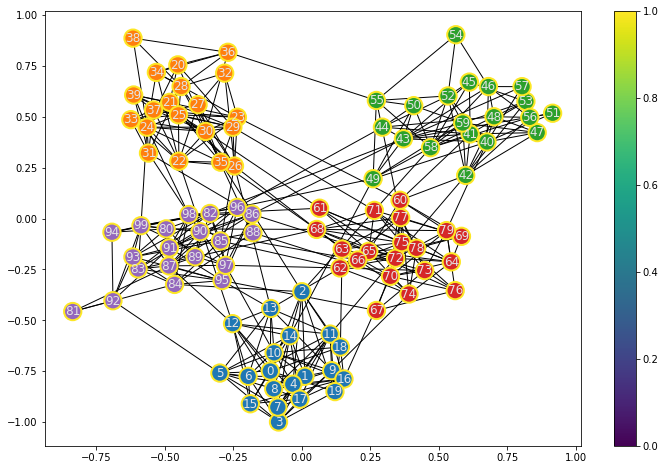

In [26]:
# Parameters
l = 5
k = 20
p_inner = .4
p_outer = .01
feature_mult = 1
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network((g, l, k), labels=labels);

In [27]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.60227 train_acc=0.35000 val_loss=1.48003 val_acc=0.30000 time=0.03646
Epoch: 0002 train_loss=1.49387 train_acc=0.40000 val_loss=1.40704 val_acc=0.47500 time=0.00237
Epoch: 0003 train_loss=1.40704 train_acc=0.55000 val_loss=1.35214 val_acc=0.53750 time=0.00260
Epoch: 0004 train_loss=1.33958 train_acc=0.60000 val_loss=1.31003 val_acc=0.55000 time=0.00238
Epoch: 0005 train_loss=1.28603 train_acc=0.60000 val_loss=1.27443 val_acc=0.55000 time=0.00239
Epoch: 0006 train_loss=1.24028 train_acc=0.60000 val_loss=1.24289 val_acc=0.55000 time=0.00494
Epoch: 0007 train_loss=1.19984 train_acc=0.60000 val_loss=1.21482 val_acc=0.55000 time=0.00376
Epoch: 0008 train_loss=1.16418 train_acc=0.70000 val_loss=1.18846 val_acc=0.55000 time=0.00224
Epoch: 0009 train_loss=1.13061 train_acc=0.70000 val_loss=1.16320 val_acc=0.56250 time=0.00217
Epoch: 0010 train_loss=1.09848 train_acc=0.70000 val_loss=1.13880 val_acc=0.57500 time=0.00217
Epoch: 0011 train_loss=1.06744 train_acc=0.70000 v

Epoch: 0089 train_loss=0.09104 train_acc=1.00000 val_loss=0.31357 val_acc=0.87500 time=0.00227
Epoch: 0090 train_loss=0.08828 train_acc=1.00000 val_loss=0.31205 val_acc=0.87500 time=0.00462
Epoch: 0091 train_loss=0.08561 train_acc=1.00000 val_loss=0.31054 val_acc=0.87500 time=0.00292
Epoch: 0092 train_loss=0.08301 train_acc=1.00000 val_loss=0.30899 val_acc=0.87500 time=0.00276
Epoch: 0093 train_loss=0.08051 train_acc=1.00000 val_loss=0.30742 val_acc=0.87500 time=0.00272
Epoch: 0094 train_loss=0.07807 train_acc=1.00000 val_loss=0.30583 val_acc=0.87500 time=0.00312
Epoch: 0095 train_loss=0.07572 train_acc=1.00000 val_loss=0.30423 val_acc=0.87500 time=0.00239
Epoch: 0096 train_loss=0.07345 train_acc=1.00000 val_loss=0.30262 val_acc=0.87500 time=0.00223
Epoch: 0097 train_loss=0.07125 train_acc=1.00000 val_loss=0.30103 val_acc=0.87500 time=0.00281
Epoch: 0098 train_loss=0.06913 train_acc=1.00000 val_loss=0.29945 val_acc=0.87500 time=0.00233
Epoch: 0099 train_loss=0.06708 train_acc=1.00000 v

Epoch: 0176 train_loss=0.01323 train_acc=1.00000 val_loss=0.24558 val_acc=0.86250 time=0.00600
Epoch: 0177 train_loss=0.01305 train_acc=1.00000 val_loss=0.24540 val_acc=0.86250 time=0.00220
Epoch: 0178 train_loss=0.01288 train_acc=1.00000 val_loss=0.24523 val_acc=0.86250 time=0.00209
Epoch: 0179 train_loss=0.01271 train_acc=1.00000 val_loss=0.24506 val_acc=0.86250 time=0.00206
Epoch: 0180 train_loss=0.01254 train_acc=1.00000 val_loss=0.24489 val_acc=0.86250 time=0.00214
Epoch: 0181 train_loss=0.01238 train_acc=1.00000 val_loss=0.24473 val_acc=0.86250 time=0.00211
Epoch: 0182 train_loss=0.01222 train_acc=1.00000 val_loss=0.24457 val_acc=0.86250 time=0.00301
Epoch: 0183 train_loss=0.01207 train_acc=1.00000 val_loss=0.24443 val_acc=0.86250 time=0.00384
Epoch: 0184 train_loss=0.01191 train_acc=1.00000 val_loss=0.24430 val_acc=0.86250 time=0.00237
Epoch: 0185 train_loss=0.01176 train_acc=1.00000 val_loss=0.24418 val_acc=0.86250 time=0.00237
Epoch: 0186 train_loss=0.01162 train_acc=1.00000 v

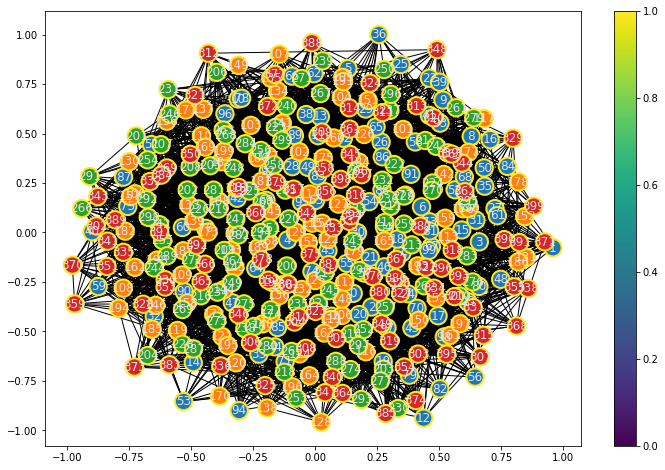

In [28]:
# Parameters
l = 4
k = 100
p_inner = .1
p_outer = .05
feature_mult = 1
feature_sigma = 1

# Show the graph
g = nx.planted_partition_graph(l, k, p_inner, p_outer)
labels = np.zeros((l * k, l))
for c in range(l):
    labels[range(c * k, (c + 1) * k), c] = 1
draw_network((g, l, k), labels=labels);

In [ ]:
# Animate training
filename = VID.format(l=l, k=k, p_inner=p_inner, p_outer=p_outer,
                      f_mult=feature_mult, f_sigma=feature_sigma)
anim, (model, arrays, session) = build_train_animation((g, l, k), labels, feature_mult, feature_sigma)
widget = anim.save(filename)
#.to_jshtml()
#.to_html5_video()
#display(HTML(widget))
print("Animation saved to '{}'".format(filename))

Epoch: 0001 train_loss=1.60227 train_acc=0.35000 val_loss=1.48003 val_acc=0.30000 time=0.03646
Epoch: 0002 train_loss=1.49387 train_acc=0.40000 val_loss=1.40704 val_acc=0.47500 time=0.00237
Epoch: 0003 train_loss=1.40704 train_acc=0.55000 val_loss=1.35214 val_acc=0.53750 time=0.00260
Epoch: 0004 train_loss=1.33958 train_acc=0.60000 val_loss=1.31003 val_acc=0.55000 time=0.00238
Epoch: 0005 train_loss=1.28603 train_acc=0.60000 val_loss=1.27443 val_acc=0.55000 time=0.00239
Epoch: 0006 train_loss=1.24028 train_acc=0.60000 val_loss=1.24289 val_acc=0.55000 time=0.00494
Epoch: 0007 train_loss=1.19984 train_acc=0.60000 val_loss=1.21482 val_acc=0.55000 time=0.00376
Epoch: 0008 train_loss=1.16418 train_acc=0.70000 val_loss=1.18846 val_acc=0.55000 time=0.00224
Epoch: 0009 train_loss=1.13061 train_acc=0.70000 val_loss=1.16320 val_acc=0.56250 time=0.00217
Epoch: 0010 train_loss=1.09848 train_acc=0.70000 val_loss=1.13880 val_acc=0.57500 time=0.00217
Epoch: 0011 train_loss=1.06744 train_acc=0.70000 v